In [52]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance")
from src.s3 import list_files_in_bucket, filter_files_by_pattern, read_parquet_from_s3
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from src.gtfs_segments import GTFS_shape_processor
from src.speeds import BusSpeedCalculator
from src.api import parse_zipped_gtfs
import geopandas as gpd
from src.api import query_feed_data, get_access_token
ACCESS_TOKEN = get_access_token()
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preparation 

In [53]:
prefix = "norm/bus-mta-vp/vehicles/"
bucket = "dataclinic-gtfs-rt"

In [54]:
def load_all_parquet_files(file_list, bucket, max_workers=100):
    dfs = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(read_parquet_from_s3, bucket, key) for key in file_list]
        for future in as_completed(futures):
            try:
                dfs.append(future.result())
            except Exception as e:
                print(f"Error reading a file: {e}")
    print(f"Read {len(dfs)} files from s3")
    return pd.concat(dfs, ignore_index=True)

## Step 0: Figure out which static feed is correct.

Pretty annoying. The trips and shapes are defined in the static gtfs feeds, and everytime a new static feed is released, the old `trip_id` values become obsolete. This is unfortunate because . It should be possible to just load all of the relevant static feeds and run a quick check on the relevant realtime feed data to see which static feed is in correct for the given dates. However, we can also just look through the outputs from MobilityData's API and find the one we want. Below, I load all the feeds for Manhattan.

In [6]:
response = query_feed_data("mdb-513", ACCESS_TOKEN)
# https://mobilitydatabase.org/feeds/mdb-513

response

[{'id': 'mdb-513-202402080022',
  'feed_id': 'mdb-513',
  'hosted_url': 'https://files.mobilitydatabase.org/mdb-513/mdb-513-202402080022/mdb-513-202402080022.zip',
  'note': None,
  'downloaded_at': '2024-02-08T00:52:25.481924Z',
  'hash': '25ebc713eff01d5d5da7e6a877926d636152417153dc591ef0763fa0851b3819',
  'bounding_box': {'minimum_latitude': 40.701536,
   'maximum_latitude': 40.865316,
   'minimum_longitude': -74.018088,
   'maximum_longitude': -73.864375},
  'validation_report': None,
  'service_date_range_start': None,
  'service_date_range_end': None},
 {'id': 'mdb-513-202404010033',
  'feed_id': 'mdb-513',
  'hosted_url': 'https://files.mobilitydatabase.org/mdb-513/mdb-513-202404010033/mdb-513-202404010033.zip',
  'note': None,
  'downloaded_at': '2024-04-01T00:26:36.207481Z',
  'hash': '4e9fce8767c4fe3eb5f0529ea49d29270543d0563d7fbf0d8c4c0920b61a3fbf',
  'bounding_box': {'minimum_latitude': 40.701536,
   'maximum_latitude': 40.865316,
   'minimum_longitude': -74.018088,
   'max

In [7]:
def fetch_all_static_feeds(mdb_id, ACCESS_TOKEN):
    response = query_feed_data(mdb_id, ACCESS_TOKEN)
    if response is None:
        raise ValueError("No response for mdb_id: ", mdb_id)
    feed_updates = pd.DataFrame(response)
    feed_updates['start_date'] = feed_updates["downloaded_at"].str.extract(r"(\d{4}-\d{2}-\d{2})")
    return feed_updates

mdb_id = "mdb-513"
feed_updates = fetch_all_static_feeds(mdb_id, ACCESS_TOKEN=ACCESS_TOKEN)
print(feed_updates)


                     id  feed_id  \
0  mdb-513-202402080022  mdb-513   
1  mdb-513-202404010033  mdb-513   
2  mdb-513-202407010038  mdb-513   
3  mdb-513-202408290052  mdb-513   
4  mdb-513-202409090026  mdb-513   
5  mdb-513-202412120015  mdb-513   
6  mdb-513-202501020055  mdb-513   
7  mdb-513-202501230024  mdb-513   

                                          hosted_url  note  \
0  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
1  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
2  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
3  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
4  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
5  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
6  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
7  https://files.mobilitydatabase.org/mdb-513/mdb...  None   

                 downloaded_at  \
0  2024-02-08T00:52:25.481924Z   
1  2024-04-01T00:26:36.207481Z   
2  2024-07-01T

# Use Case 1: Bus Speed Comparsion

Roadmap:
1. date
2. route_id
3. url (date -> url)
4. segment_df (route_id + url -> segment_df)

- Bus Route: M50
- Date: Dec 2024 and Jan 2025, Thursday only
- Time: Aggregated average speed for each hour / half hour
- Plot: Line graph for each date 


In [10]:
bucket = "dataclinic-gtfs-rt"

def get_correct_static_url(feed_updates, date):
    candidates = feed_updates[feed_updates["start_date"] < date]
    if candidates.empty:
        print(f"No static feed found before {date}")
        return None
    else:
        # return the last row which should be the latest static feed
        return candidates.iloc[-1]["hosted_url"]

def calculate_speeds_for_route(bucket, date, route_id):
    # Step 0: Get the correct static feed and specify the url based on the date given
    correct_url = get_correct_static_url(feed_updates, date)

    # Step 1: Process static feed shapes into geodataframe
    # this takes 2.5 seconds, which can be improved 
    segment_df = GTFS_shape_processor(correct_url, 4326, 2263).process_shapes()

    # Step 2: Load relevant realtime data from s3 bucket for the given date
    daily_files = list_files_in_bucket(bucket_name = bucket, prefix = f"{prefix}date={date}/")
    vehicle_positions = load_all_parquet_files(file_list = daily_files, bucket = bucket)
    GTFS_dict = parse_zipped_gtfs(correct_url)

    # Step 3: Calculate speeds
    speed_calculator = BusSpeedCalculator(vehicle_positions, GTFS_dict, segment_df)
    speeds = speed_calculator.create_trip_speeds()
    speeds = speed_calculator.match_trip_with_route(speeds)
    
    # remove outlier
    speeds = speeds[speeds["route_id"] == route_id]
    speeds = speeds[speeds["speed_mph"] < 70]
    return speeds



In [12]:
def get_all_weekdays(start_date: str, end_date: str, weekday_type: int):
    # 0 - Monday, 1 - Tuesday, ..., 6 - Sunday
    # return a list of date strings
    dates = []
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    for date in date_range:
        if date.weekday() == weekday_type:
            dates.append(date.strftime('%Y-%m-%d'))
    return dates

ans = get_all_weekdays("2025-01-01", "2025-01-31", 0) # get all mondays
print(ans)

['2025-01-06', '2025-01-13', '2025-01-20', '2025-01-27']


In [16]:
bucket = "dataclinic-gtfs-rt"
route_id = "M50"

weekday_type = 0
experiment_mondays = get_all_weekdays("2025-01-05", "2025-01-31", weekday_type)
comparison_mondays = get_all_weekdays("2024-12-05", "2024-12-31", weekday_type)

print(experiment_mondays)
print(comparison_mondays)

# Create directories if they do not exist
os.makedirs("data/2025-jan/", exist_ok=True)
os.makedirs("data/2024-dec/", exist_ok=True)

# Process experiment mondays
for date in experiment_mondays:
    speeds = calculate_speeds_for_route(bucket, date, route_id)
    speeds.to_csv(os.path.join("data/2025-jan/", f"speeds_{route_id}_{date}.csv"))
    print(f"Saved speeds for {route_id} on {date}")

# Process comparison mondays
for date in comparison_mondays:
    speeds = calculate_speeds_for_route(bucket, date, route_id)
    speeds.to_csv(os.path.join("data/2024-dec/", f"speeds_{route_id}_{date}.csv"))
    print(f"Saved speeds for {route_id} on {date}")

['2025-01-06', '2025-01-13', '2025-01-20', '2025-01-27']
['2024-12-09', '2024-12-16', '2024-12-23', '2024-12-30']
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1403 files from s3
Parsed GTFS static feed data successfully
Processing 9755 trips...


100%|██████████| 9755/9755 [02:08<00:00, 76.12it/s] 


Saved speeds for M50 on 2025-01-06
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1402 files from s3
Parsed GTFS static feed data successfully
Processing 9945 trips...


100%|██████████| 9945/9945 [02:09<00:00, 77.05it/s]


Saved speeds for M50 on 2025-01-13
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1404 files from s3
Parsed GTFS static feed data successfully
Processing 8407 trips...


100%|██████████| 8407/8407 [01:37<00:00, 85.80it/s] 


Saved speeds for M50 on 2025-01-20
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1405 files from s3
Parsed GTFS static feed data successfully
Processing 9859 trips...


100%|██████████| 9859/9859 [02:09<00:00, 75.97it/s]


Saved speeds for M50 on 2025-01-27
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1402 files from s3
Parsed GTFS static feed data successfully
Processing 9718 trips...


100%|██████████| 9718/9718 [02:02<00:00, 79.34it/s] 


Saved speeds for M50 on 2024-12-09
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1403 files from s3
Parsed GTFS static feed data successfully
Processing 9390 trips...


100%|██████████| 9390/9390 [01:52<00:00, 83.41it/s] 


Saved speeds for M50 on 2024-12-16
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1403 files from s3
Parsed GTFS static feed data successfully
Processing 9633 trips...


100%|██████████| 9633/9633 [01:59<00:00, 80.51it/s] 


Saved speeds for M50 on 2024-12-23
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1403 files from s3
Parsed GTFS static feed data successfully
Processing 8746 trips...


100%|██████████| 8746/8746 [01:40<00:00, 87.06it/s] 


Saved speeds for M50 on 2024-12-30


TODO:

take M50 as an example
- two versions of data visualization: 1. bus speed by half hour 2. bus commuting time 
- visualization of the selected area and the bus route
- data warehousing design: 1. storage format 2. storage schema



core bus speed calculation

trip_segments["speed_mph"] = (
    (trip_segments["segment_length"] / trip_segments["time_elapsed"]) * 0.681818
)


In [8]:
def calculate_speeds_metric_daily(date: str, speeds: pd.DataFrame):
    # calculcate the average speed for each hour
    speeds["hour"] = speeds["interpolated_time"].dt.hour
    
    # aggregate segment_length and time_elapsed by hour
    average_speed_df = speeds.groupby('hour').agg(
        total_segment_length=('segment_length', 'sum'),
        total_time_elapsed=('time_elapsed', 'sum')
    ).reset_index()

    # calculate average speed for each hour
    average_speed_df['average_speed_mph'] = (
        average_speed_df['total_segment_length'] / average_speed_df['total_time_elapsed']
    )

    # keep only the relevant columns
    average_speed_df = average_speed_df[["route_id", "hour", "average_speed_mph"]]
    average_speed_df["date"] = date

    return average_speed_df

Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


<Axes: >

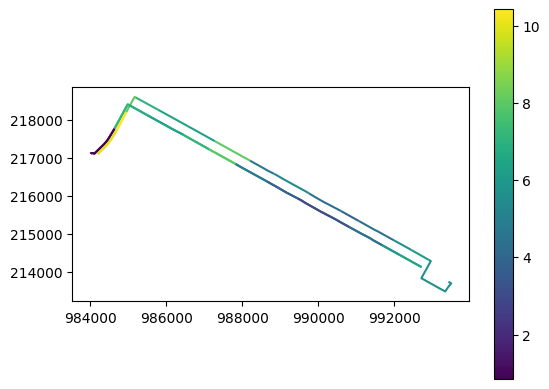

In [14]:
# plot the segment of a trip with median speed of the day
date = "2025-01-06"
route_id = "M50"
correct_url = get_correct_static_url(feed_updates, date)
segment_df = GTFS_shape_processor(correct_url, 4326, 2263).process_shapes()
speeds = pd.read_csv(f"data/2025-jan/speeds_{route_id}_{date}.csv")
segment_df.merge(speeds.groupby(["prev_stop_id", "stop_id"])["speed_mph"].median().reset_index()).plot(column="speed_mph", legend=True)

# Use Case 2: Bus Travel Time Comparison

- Bus Route: M50
- Date: Dec 2024 and Jan 2025, Thursday only
- Time: Traveling Time for the route, by half hour

In [55]:
bucket = "dataclinic-gtfs-rt"
route_id = "M50"

In [56]:
def get_bus_travel_time(bucket, date, route_id):
    daily_files = list_files_in_bucket(bucket_name = bucket, prefix = f"{prefix}date={date}/")
    buses = load_all_parquet_files(file_list = daily_files, bucket = bucket)

    # select only route_id 
    buses = buses[buses["trip.route_id"] == route_id]

    # create unique trip id for each trip
    buses["unique_trip_id"] = (
                buses["trip.trip_id"].astype(str) +
                buses["id"].astype(str) +
                buses["trip.start_date"].astype(str) +
                buses["trip.direction_id"].astype(str)
            )
    
    # order by unique_trip_id  
    buses = buses.sort_values(by="unique_trip_id")

    # order by timestamp
    # timestamp is more accurate than time, we will use timestamp as the ground truth from now on 
    buses = buses.sort_values(by="timestamp")

    # TODO: filter out the segments that are in the congestion zone area

    # create new df with: trip_id, route_id, direction_id, start_date, trip_start_time, trip_end_time, trip_duration, unique_trip_id
    # trip_start_time = first timestamp of the trip
    # trip_end_time = last timestamp of the trip
    # trip_duration = trip_end_time - trip_start_time
    bus_trips = buses.groupby("unique_trip_id").agg(
        trip_id = ("trip.trip_id", "first"),
        route_id = ("trip.route_id", "first"),
        direction_id = ("trip.direction_id", "first"),
        start_date = ("trip.start_date", "first"),
        trip_start_timestamp = ("timestamp", "min"),
        trip_end_timestamp = ("timestamp", "max"),
    ).reset_index()

    bus_trips["trip_duration_sec"] = bus_trips["trip_end_timestamp"] - bus_trips["trip_start_timestamp"]
    bus_trips["interpolated_time"] = (bus_trips["trip_start_timestamp"] + bus_trips["trip_end_timestamp"]) / 2
    bus_trips["interpolated_time"] = pd.to_datetime(bus_trips["interpolated_time"], unit="s")

    # delete those duration == 0
    bus_trips = bus_trips[bus_trips["trip_duration_sec"] > 0]

    print("Fetched trips success, shape: ", bus_trips.shape)
    return bus_trips

In [59]:
# fetching the trips
bus_trips_250106 = get_bus_travel_time(bucket, "2025-01-06", "M50")
bus_trips_241206 = get_bus_travel_time(bucket, "2024-12-06", "M50")


Read 1403 files from s3
(121, 9)
Read 1403 files from s3
(106, 9)


/var/folders/ms/n7l6fpkd7bzbgn2k868rryv00000gn/T/ipykernel_87567/2597626038.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_250106["hour"] = bus_trips_250106["interpolated_time"].dt.floor("H").dt.strftime("%H")
/var/folders/ms/n7l6fpkd7bzbgn2k868rryv00000gn/T/ipykernel_87567/2597626038.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_241206["hour"] = df_241206["interpolated_time"].dt.floor("H").dt.strftime("%H")


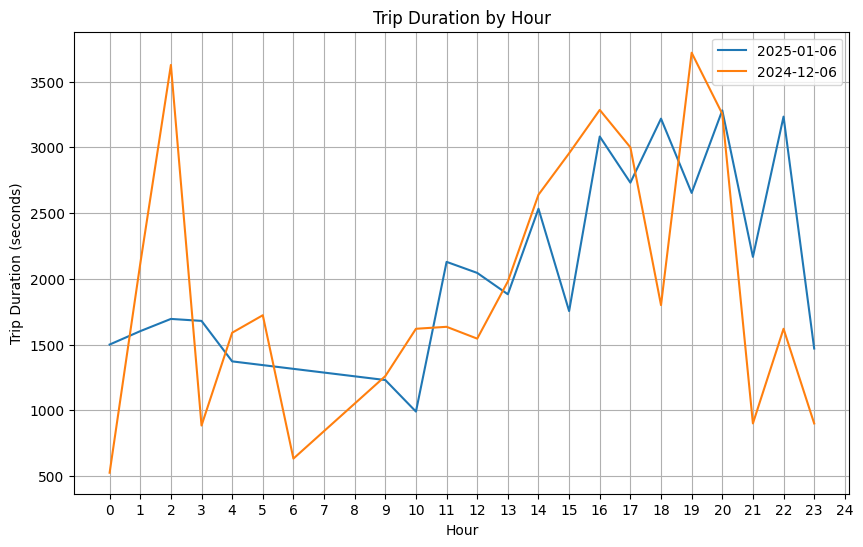

    hour route_id  trip_duration_sec
0      0      M50              525.0
1      1      M50             2115.0
2      2      M50             3627.0
3      3      M50              884.0
4      4      M50             1590.0
5      5      M50             1723.0
6      6      M50              632.5
7      9      M50             1260.0
8     10      M50             1620.0
9     11      M50             1635.0
10    12      M50             1545.0
11    13      M50             1980.0
12    14      M50             2640.0
13    15      M50             2955.0
14    16      M50             3285.0
15    17      M50             3000.0
16    18      M50             1800.0
17    19      M50             3720.0
18    20      M50             3255.0
19    21      M50              900.0
20    22      M50             1620.0
21    23      M50              900.0


In [68]:
# Visualization

# line plot of the average trip duration by interpolated time(half hour, drop date)
df_250106 = bus_trips_250106.copy()
df_250106["hour"] = bus_trips_250106["interpolated_time"].dt.floor("H").dt.strftime("%H")
df_250106 = df_250106.groupby(["hour", "route_id"]).agg(
    trip_duration_sec = ("trip_duration_sec", "median")
).reset_index()

df_241206 = bus_trips_241206.copy()
df_241206["hour"] = df_241206["interpolated_time"].dt.floor("H").dt.strftime("%H")
df_241206 = df_241206.groupby(["hour", "route_id"]).agg(
    trip_duration_sec = ("trip_duration_sec", "median")
).reset_index()

# Ensure hour is an integer
df_250106["hour"] = df_250106["hour"].astype(int)
df_241206["hour"] = df_241206["hour"].astype(int)

# line plot 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df_250106["hour"], df_250106["trip_duration_sec"], label="2025-01-06")
plt.plot(df_241206["hour"], df_241206["trip_duration_sec"], label="2024-12-06")
plt.title("Trip Duration by Hour")
plt.xlabel("Hour")
plt.ylabel("Trip Duration (seconds)")
plt.xticks(range(0, 25))
plt.legend()
plt.grid(True)
plt.show()

print(df_241206)